In [59]:
import os
import math
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization, LeakyReLU, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
tf.random.set_seed(42)

In [60]:
class DataProcessor:
    def __init__(self, base_path):
        self.base_path = base_path
        self.image_size = (360, 360)
        self.label_encoder = None
    
    def apply_augmentation(self, image, bbox):
        bbox = tf.cast(bbox, tf.float32)
        
        h, w = float(self.image_size[0]), float(self.image_size[1])
        bbox_pixel = bbox * tf.constant([w, h, w, h], dtype=tf.float32)
        
        if tf.random.uniform([]) > 0.5:
            image = tf.image.flip_left_right(image)
            bbox_pixel = tf.stack([
                w - bbox_pixel[2],
                bbox_pixel[1],    
                w - bbox_pixel[0], 
                bbox_pixel[3]      
            ])
        
        if tf.random.uniform([]) > 0.5:
            angle = tf.random.uniform([], minval=-15, maxval=15) * math.pi / 180
            image = tf.keras.layers.RandomRotation(
                factor=(-15/360, 15/360),
                fill_mode='constant',
                fill_value=1.0
            )(image)
            
            center_x = (bbox_pixel[0] + bbox_pixel[2]) / 2
            center_y = (bbox_pixel[1] + bbox_pixel[3]) / 2
            width = bbox_pixel[2] - bbox_pixel[0]
            height = bbox_pixel[3] - bbox_pixel[1]
            
            cos_theta = tf.cos(angle)
            sin_theta = tf.sin(angle)
            new_center_x = (center_x - w/2) * cos_theta - (center_y - h/2) * sin_theta + w/2
            new_center_y = (center_x - w/2) * sin_theta + (center_y - h/2) * cos_theta + h/2
            
            expansion_factor = 1.2
            new_width = width * expansion_factor
            new_height = height * expansion_factor
            
            bbox_pixel = tf.stack([
                tf.clip_by_value(new_center_x - new_width/2, 0, w),
                tf.clip_by_value(new_center_y - new_height/2, 0, h),
                tf.clip_by_value(new_center_x + new_width/2, 0, w),
                tf.clip_by_value(new_center_y + new_height/2, 0, h)
            ])
        
        if tf.random.uniform([]) > 0.5:
            zoom_factor = tf.random.uniform([], minval=0.9, maxval=1.0)
            image = tf.image.central_crop(image, zoom_factor)
            image = tf.image.resize(image, self.image_size)
            
            bbox_pixel = bbox_pixel * zoom_factor
            bbox_pixel = tf.clip_by_value(bbox_pixel, 0, tf.maximum(w, h))
        
        if tf.random.uniform([]) > 0.5:
            image = tf.image.random_brightness(image, 0.2)
            image = tf.image.random_contrast(image, 0.8, 1.2)
            image = tf.image.random_saturation(image, 0.8, 1.2)
            image = tf.image.random_hue(image, 0.1)
        
        if tf.random.uniform([]) > 0.5:
            noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.01)
            image = tf.clip_by_value(image + noise, 0.0, 1.0)
        
        bbox = bbox_pixel / tf.constant([w, h, w, h], dtype=tf.float32)
        return image, bbox

    def load_and_preprocess_image(self, filename, label, bbox):
        try:
            img = tf.io.read_file(filename)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, self.image_size)
            img = tf.cast(img, tf.float32) / 255.0
            
            img, bbox = self.apply_augmentation(img, bbox)
            
            return img, label, bbox
        except tf.errors.NotFoundError:
            tf.print(f"File not found: {filename}")
            return None, None, None
            
    def create_dataset(self, csv_file, base_dir, is_training=True, batch_size=16):
        df = pd.read_csv(csv_file)
        
        if self.label_encoder is None:
            self.label_encoder = LabelEncoder()
            df['class'] = self.label_encoder.fit_transform(df['class'])
        else:
            df['class'] = self.label_encoder.transform(df['class'])
            
        filenames = df['filename'].apply(lambda x: os.path.join(base_dir, x)).values
        labels = df['class'].values
        labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=len(self.label_encoder.classes_))
        
        bboxes = df[['xmin', 'ymin', 'xmax', 'ymax']].values.astype(np.float32)
        
        bboxes = bboxes / np.array([self.image_size[1], self.image_size[0], 
                                   self.image_size[1], self.image_size[0]], 
                                   dtype=np.float32)
        
        dataset = tf.data.Dataset.from_tensor_slices((filenames, labels_one_hot, bboxes))
        dataset = dataset.map(
            lambda f, l, b: (self.load_and_preprocess_image(f, l, b)),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.filter(lambda x, y, z: x is not None)
        
        def prepare_data(img, label, bbox):
            return img, {'class_output': label, 'bbox_output': bbox}
        
        dataset = dataset.map(prepare_data)
        
        if is_training:
            dataset = dataset.shuffle(buffer_size=1000)
        
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        
        return dataset


In [61]:

class VisionModel:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.model = self._build_model()
        
    def _build_model(self):
        inputs = Input(shape=(360, 360, 3))
        
        base_model = base_model = VGG16(weights='imagenet', include_top=False, input_shape=(360, 360, 3))
        for layer in base_model.layers[:-4]:  # Freeze all layers except the last 4
            layer.trainable = False

        for layer in base_model.layers:
            if isinstance(layer, Conv2D):
                layer.kernel_initializer = tf.keras.initializers.HeNormal()
        
        x = base_model(inputs, training=True)
        
        def conv_block(x, filters):
            x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.1)(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)
            return x
            
        x = conv_block(x, 64)
        x = conv_block(x, 128)
        
        x = GlobalAveragePooling2D()(x)
        
        def fc_block(x, units, dropout_rate=0.5):
            skip = x
            x = Dense(units)(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.1)(x)
            x = Dropout(dropout_rate)(x)
            if skip.shape[-1] == units:
                x = x + skip
            return x
            
        x = fc_block(x, 512)
        x = fc_block(x, 256)
        #modify_test
        #x = fc_block(x, 128)
        #x = fc_block(x, 64)
        
        class_output = Dense(self.num_classes, activation='softmax', name='class_output')(x)
        bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(x)  
        
        model = Model(inputs=inputs, outputs=[class_output, bbox_output])
        return model
        
    def compile_model(self, learning_rate=0.0001):
        optimizer = AdamW(
            learning_rate=learning_rate,
            weight_decay=0.0001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07
        )
        
        self.model.compile(
            optimizer=optimizer,
            loss={
                'class_output': 'categorical_crossentropy',
                'bbox_output': 'huber' 
            },
            loss_weights={'class_output': 1.0, 'bbox_output': 1.0},
            metrics={
                'class_output': ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2)],
                'bbox_output': ['mae', tf.keras.metrics.MeanSquaredError()]
            }
        )
    
    def get_callbacks(self, model_dir='model'):
        callbacks = [
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=1
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            ModelCheckpoint(
                os.path.join(model_dir, 'model-{epoch:02d}-{val_loss:.2f}.keras'),
                monitor='val_loss',
                save_best_only=True,
                verbose=1,
                save_weights_only=False
            )
        ]
        return callbacks


In [62]:
def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['class_output_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()


In [63]:

def train_model():
    base_path = 'dataset/'
    data_processor = DataProcessor(base_path)
    
    train_dataset = data_processor.create_dataset(
        os.path.join(base_path, 'train', '_annotations.csv'),
        os.path.join(base_path, 'train'),
        is_training=True
    )
    
    valid_dataset = data_processor.create_dataset(
        os.path.join(base_path, 'valid', '_annotations.csv'),
        os.path.join(base_path, 'valid'),
        is_training=False
    )
    
    model = VisionModel(num_classes=len(data_processor.label_encoder.classes_))
    model.compile_model()
    
    history = model.model.fit(
        train_dataset,
        epochs=100,
        validation_data=valid_dataset,
        callbacks=model.get_callbacks(),
        workers=4,
        use_multiprocessing=True
    )
    
    model_save_path = 'model/my_model.h5'
    model.model.save(model_save_path)
    print(f'Model saved to: {model_save_path}')
    plot_metrics(history)
    return model, history, data_processor


In [64]:
model, history, data_processor = train_model()

Epoch 1/100
    200/Unknown - 975s 5s/step - loss: 1.7612 - class_output_loss: 1.6928 - bbox_output_loss: 0.0683 - class_output_accuracy: 0.3484 - class_output_top_k_categorical_accuracy: 0.6087 - bbox_output_mae: 0.2986 - bbox_output_mean_squared_error: 0.1367
Epoch 1: val_loss improved from inf to 1.74640, saving model to model\model-01-1.75.keras
200/200 [==============================] - 1164s 6s/step - loss: 1.7612 - class_output_loss: 1.6928 - bbox_output_loss: 0.0683 - class_output_accuracy: 0.3484 - class_output_top_k_categorical_accuracy: 0.6087 - bbox_output_mae: 0.2986 - bbox_output_mean_squared_error: 0.1367 - val_loss: 1.7464 - val_class_output_loss: 1.6918 - val_bbox_output_loss: 0.0546 - val_class_output_accuracy: 0.4286 - val_class_output_top_k_categorical_accuracy: 0.5714 - val_bbox_output_mae: 0.2875 - val_bbox_output_mean_squared_error: 0.1091 - lr: 1.0000e-04
Epoch 2/100
 90/200 [============>.................] - ETA: 8:39 - loss: 1.5015 - class_output_loss: 1.4547 

KeyboardInterrupt: 

23/23 [==============================] - 86s 4s/step
Classification Report:
              precision    recall  f1-score   support

     HandGun       0.59      0.71      0.64        95
       Rifle       0.53      0.87      0.66       107
         SMG       0.88      0.27      0.42        81
     ShotGun       0.80      0.51      0.62        81

    accuracy                           0.61       364
   macro avg       0.70      0.59      0.59       364
weighted avg       0.69      0.61      0.59       364



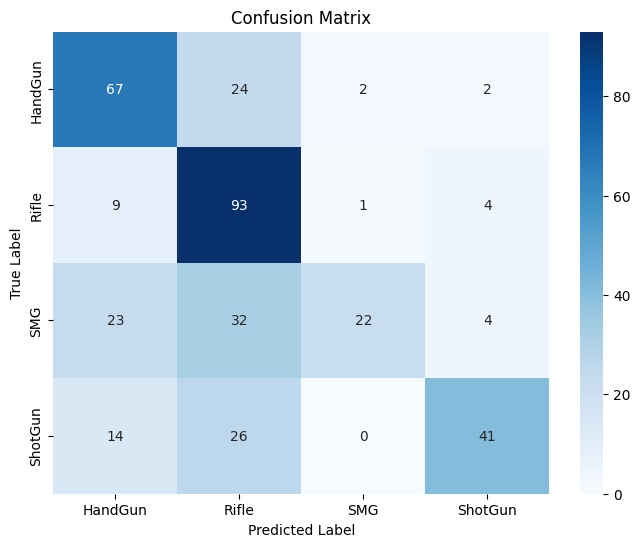

In [50]:

test_dataset = data_processor.create_dataset(
        os.path.join('dataset', 'test', '_annotations.csv'),
        os.path.join('dataset', 'test'),
        is_training=False
    )

    # Predictions on test data
class_pred, bbox_pred = model.model.predict(test_dataset)
class_pred_labels = np.argmax(class_pred, axis=1)

    # Extract true class labels from test dataset
true_class_labels = []
for images, labels in test_dataset.unbatch():
    true_class_labels.append(np.argmax(labels['class_output']))

true_class_labels = np.array(true_class_labels)

    # Classification report
print("Classification Report:")
print(classification_report(true_class_labels, class_pred_labels, target_names=data_processor.label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(true_class_labels, class_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=data_processor.label_encoder.classes_, yticklabels=data_processor.label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [53]:
# Evaluate the model

results = model.model.evaluate(test_dataset)

# Unpack the results
test_loss, class_output_loss, bbox_output_loss, test_accuracy, top_k_categorical_accuracy, bbox_output_mae, bbox_output_mean_squared_error = results

# Print the relevant metrics
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')
print(f'Bounding Box MAE: {bbox_output_mae}, Bounding Box MSE: {bbox_output_mean_squared_error}')
print(f'Top-k Categorical Accuracy: {top_k_categorical_accuracy}')


23/23 [==============================] - 91s 4s/step - loss: 0.9847 - class_output_loss: 0.9584 - bbox_output_loss: 0.0263 - class_output_accuracy: 0.6374 - class_output_top_k_categorical_accuracy: 0.8654 - bbox_output_mae: 0.1900 - bbox_output_mean_squared_error: 0.0526
Test Accuracy: 0.6373626589775085, Test Loss: 0.9846832752227783
Bounding Box MAE: 0.19000621140003204, Bounding Box MSE: 0.05259295180439949
Top-k Categorical Accuracy: 0.8653846383094788


In [54]:
from tensorflow.keras.models import load_model
model = load_model('model\model-06-0.95.keras')

In [55]:
base_path = 'dataset/'
data_processor = DataProcessor(base_path)
test_dataset = data_processor.create_dataset(
    os.path.join(base_path, 'test', '_annotations.csv'),
    os.path.join(base_path, 'test'),
    is_training=False
)

y_pred = model.predict(test_dataset)
print(y_pred)

23/23 [==============================] - 89s 4s/step
[array([[8.2664931e-01, 3.8271852e-02, 7.6228619e-02, 5.8850218e-02],
       [8.7203830e-04, 9.4210958e-01, 9.9596558e-03, 4.7058679e-02],
       [5.7087004e-02, 2.6546903e-02, 9.1464901e-01, 1.7171147e-03],
       ...,
       [1.6177263e-02, 8.4932733e-01, 4.0757660e-02, 9.3737766e-02],
       [2.2457274e-02, 8.5998970e-01, 4.6659976e-02, 7.0893101e-02],
       [1.9932473e-02, 8.7068820e-01, 6.4144090e-02, 4.5235232e-02]],
      dtype=float32), array([[0.28076565, 0.34700003, 0.64456606, 0.6881336 ],
       [0.26674795, 0.18565209, 0.84609413, 0.84084916],
       [0.09974948, 0.10283715, 0.82348776, 0.771649  ],
       ...,
       [0.36606315, 0.2722336 , 0.68353575, 0.5824978 ],
       [0.33905953, 0.2759517 , 0.61947703, 0.5792663 ],
       [0.3927658 , 0.2614433 , 0.6651895 , 0.58009666]], dtype=float32)]


In [56]:
# Load test dataset CSV file and encode true labels
test_csv_path = os.path.join(base_path, 'test', '_annotations.csv')
df_test = pd.read_csv(test_csv_path)

# Encode class labels using the same LabelEncoder
if data_processor.label_encoder is None:
    data_processor.label_encoder = LabelEncoder()
    data_processor.label_encoder.fit(df_test['class'])

# Convert class labels to integers for true labels
true_labels = data_processor.label_encoder.transform(df_test['class'])

class_predictions, bbox_predictions = y_pred  # Extract class and bbox predictions

# Convert predicted probabilities to class labels
predicted_classes = class_predictions.argmax(axis=1)

# Classification report for precision, recall, and F1-score
print(classification_report(true_labels, predicted_classes, target_names=data_processor.label_encoder.classes_))


              precision    recall  f1-score   support

     HandGun       0.61      0.75      0.67        95
       Rifle       0.56      0.91      0.69       107
         SMG       0.86      0.23      0.37        81
     ShotGun       0.83      0.54      0.66        81

    accuracy                           0.63       364
   macro avg       0.72      0.61      0.60       364
weighted avg       0.70      0.63      0.61       364



1/1 [==============================] - 0s 470ms/step
Predicted boxes shape: (4,)
True boxes shape: (4,)
Image shape: (360, 360, 3)
1/1 [==============================] - 1s 549ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28968367..1.127243].


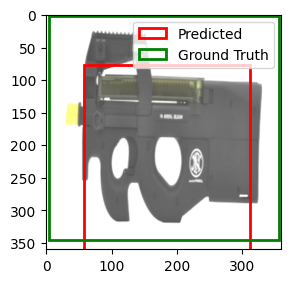

1/1 [==============================] - 0s 287ms/step


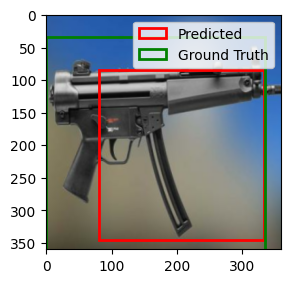

1/1 [==============================] - 0s 323ms/step


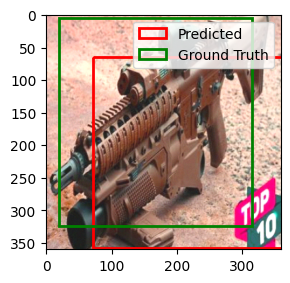

1/1 [==============================] - 0s 313ms/step


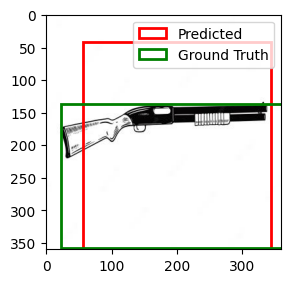

1/1 [==============================] - 0s 270ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15350203..0.91482794].


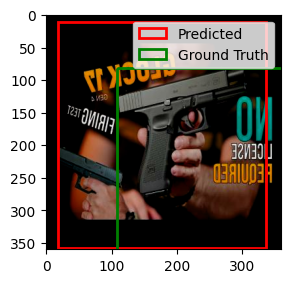

In [57]:
def plot_image_with_boxes(image, pred_boxes, true_boxes=None):
    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='gray')
    
    # Get image dimensions
    height, width = image.shape[:2]

    # Draw predicted box

    if pred_boxes is not None:
        # Extract the box from the nested array and denormalize coordinates
        box = pred_boxes[0]  # Get the first (and only) box
        x = box[0] * width
        y = box[1] * height
        w = box[2] * width
        h = box[3] * height
        
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, 
                                        fill=False, 
                                        color='red', 
                                        linewidth=2,
                                        label='Predicted'))
    
    # Draw ground truth box
    if true_boxes is not None:
        # Extract the box from the nested array and denormalize coordinates
        box = true_boxes[0]  # Get the first (and only) box
        x = box[0] * width
        y = box[1] * height
        w = box[2] * width
        h = box[3] * height
        
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, 
                                        fill=False, 
                                        color='green', 
                                        linewidth=2,
                                        label='Ground Truth'))
    
    plt.legend()
    plt.axis('on')
    plt.tight_layout()
    plt.show()

test_dataset_iter = iter(test_dataset)  
batch = next(test_dataset_iter)  

image = batch[0][0].numpy()  
true_boxes = batch[1]['bbox_output'][0].numpy()  

pred_boxes = model.predict(image[np.newaxis, ...])[1][0]  
print("Predicted boxes shape:", pred_boxes.shape)
print("True boxes shape:", true_boxes.shape)
print("Image shape:", image.shape)

num_images = 5 
for i, batch in enumerate(test_dataset.take(num_images)):
    
    image = batch[0][0].numpy()
    true_boxes = batch[1]['bbox_output'][0].numpy()
    
    pred_boxes = model.predict(image[np.newaxis, ...])[1][0]
    
    plot_image_with_boxes(image, [pred_boxes], [true_boxes])
    
    if i >= num_images - 1:
        break  

# single object plot bbox

1/1 [==============================] - 0s 492ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.21800333..1.0857589].


1/1 [==============================] - 0s 259ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1488793].


1/1 [==============================] - 0s 259ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06805587..1.1648281].


1/1 [==============================] - 0s 257ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07571827..1.0153456].


1/1 [==============================] - 0s 241ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.028384387..0.8895134].


1/1 [==============================] - 0s 254ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10077858..1.0891848].


1/1 [==============================] - 0s 250ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10434571..0.89831316].


1/1 [==============================] - 0s 250ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01743678..1.017719].


1/1 [==============================] - 0s 253ms/step


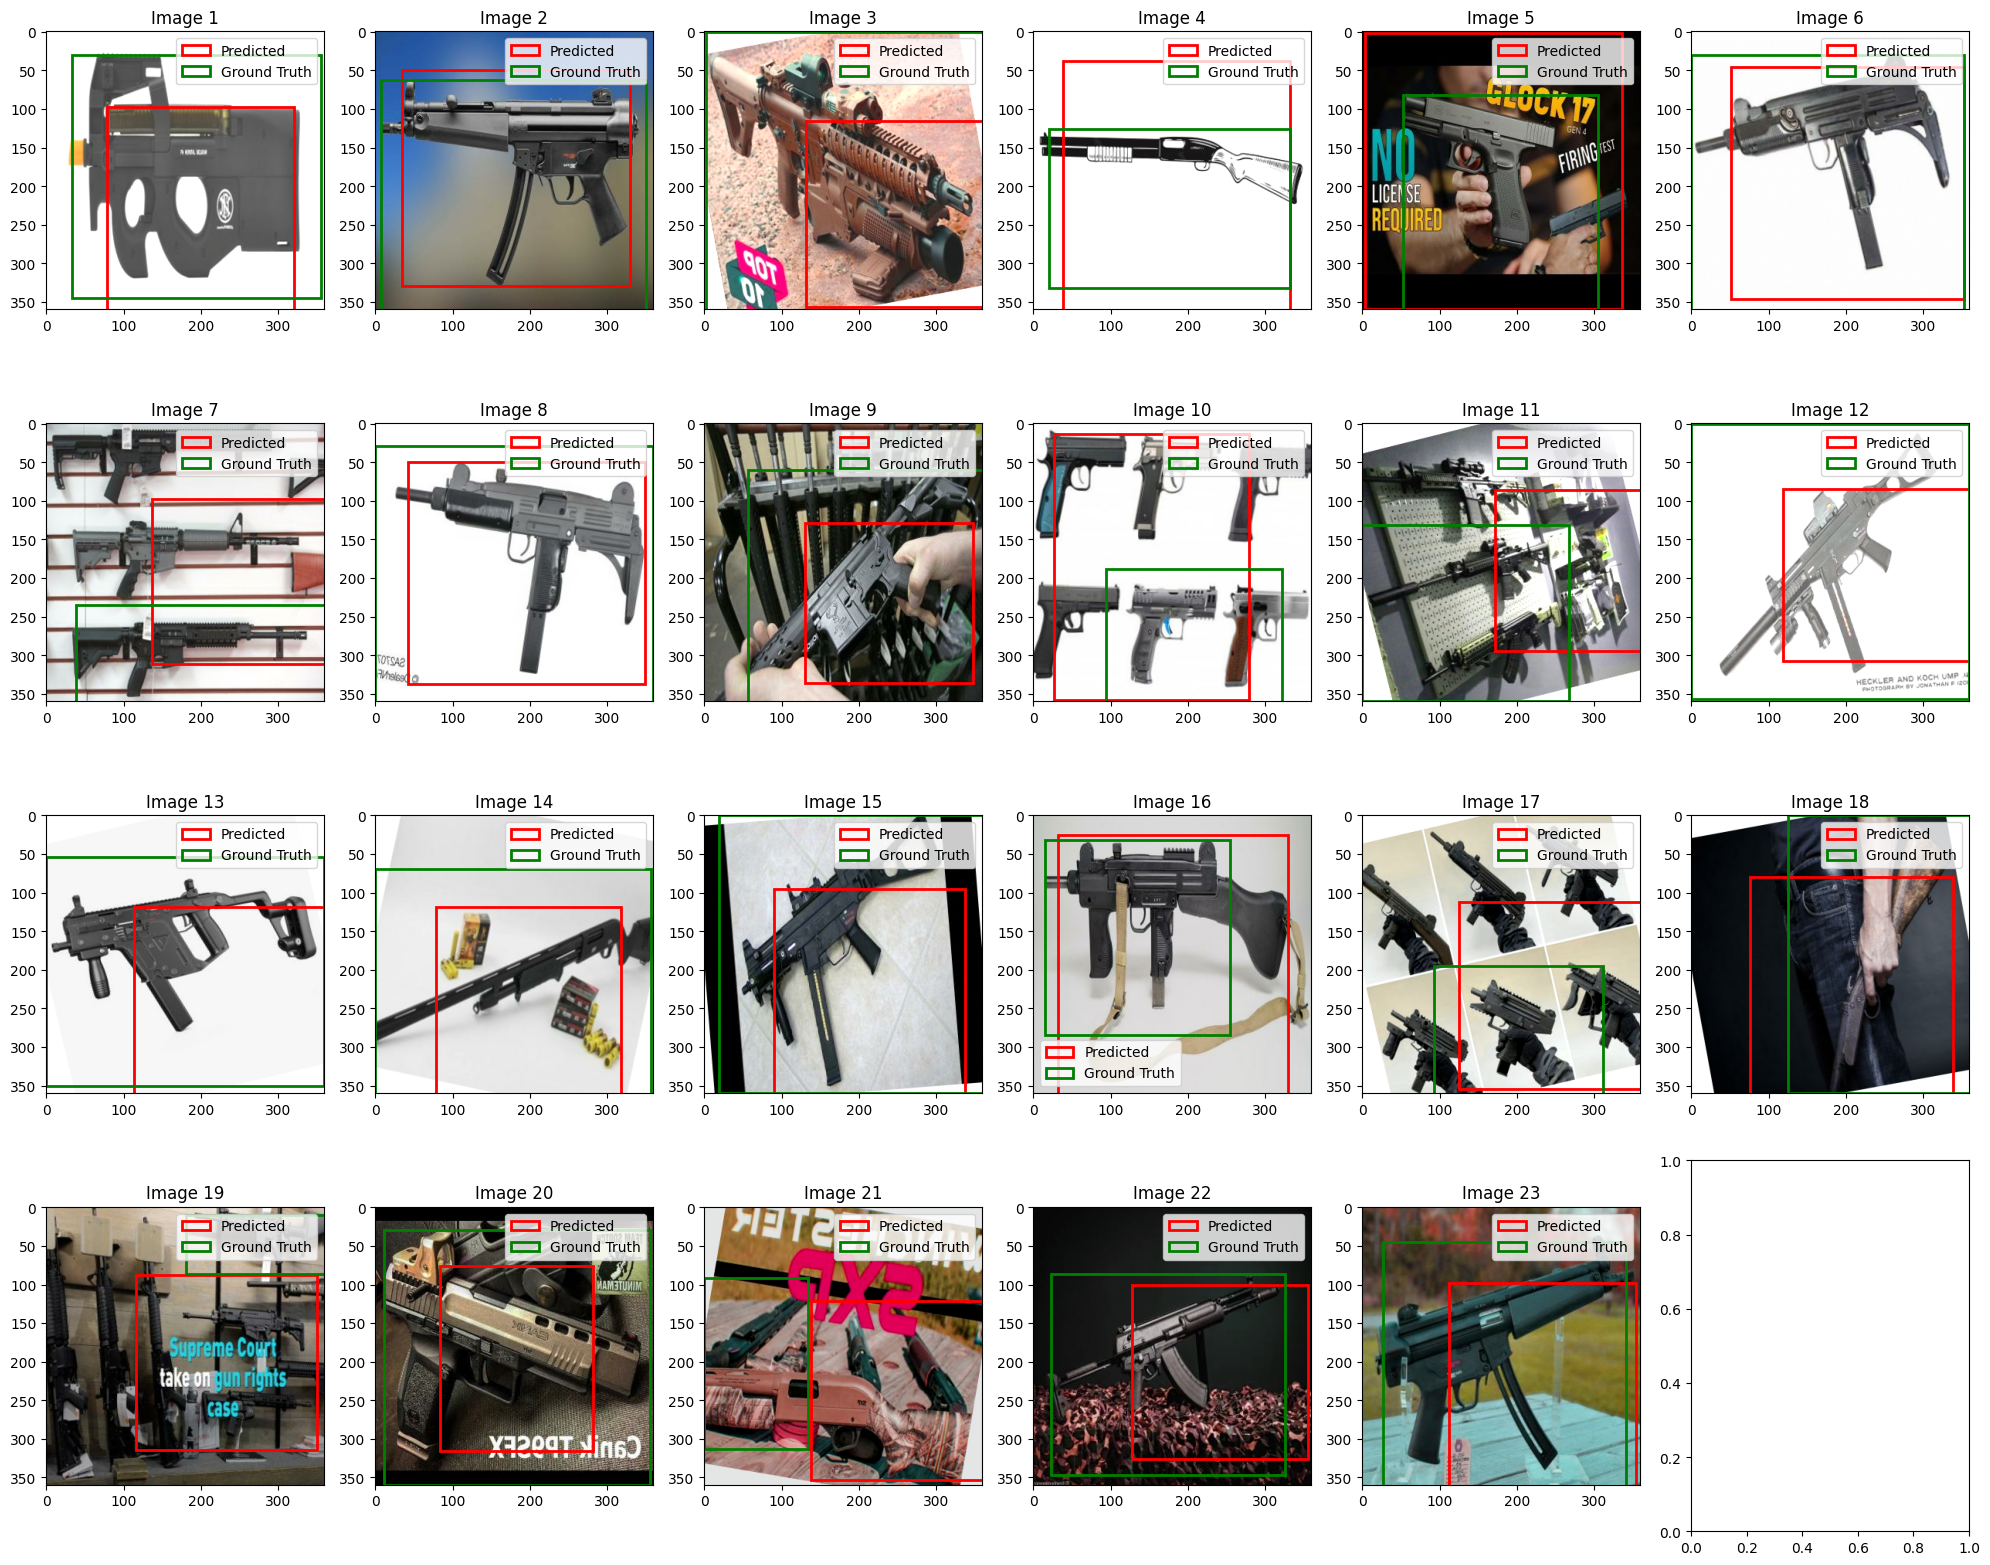

In [58]:
def plot_image_with_boxes(image, pred_boxes, true_boxes=None, ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.imshow(image, cmap='gray')
    
    height, width = image.shape[:2]
    
    if pred_boxes is not None:
        box = pred_boxes[0]
        x = box[0] * width
        y = box[1] * height
        w = box[2] * width
        h = box[3] * height
        
        ax.add_patch(plt.Rectangle((x, y), w, h, 
                                 fill=False, 
                                 color='red', 
                                 linewidth=2,
                                 label='Predicted'))
    
    if true_boxes is not None:
        box = true_boxes[0]
        x = box[0] * width
        y = box[1] * height
        w = box[2] * width
        h = box[3] * height
        
        ax.add_patch(plt.Rectangle((x, y), w, h, 
                                 fill=False, 
                                 color='green', 
                                 linewidth=2,
                                 label='Ground Truth'))
    
    ax.legend()

def plot_multiple_images(test_dataset, num_images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4*rows))
    axes = axes.ravel() 
    
    for i, batch in enumerate(test_dataset.take(num_images)):
        if i >= num_images:
            break
            
        image = batch[0][0].numpy()
        true_boxes = batch[1]['bbox_output'][0].numpy()
        
        pred_boxes = model.predict(image[np.newaxis, ...])[1][0]
        
        plot_image_with_boxes(image, [pred_boxes], [true_boxes], ax=axes[i])
        axes[i].set_title(f'Image {i+1}')
    
    plt.tight_layout()
    plt.show()

num_images = 30  
rows = 4      
cols = 6        

plot_multiple_images(test_dataset, num_images, rows, cols)

1/1 [==============================] - 0s 209ms/step


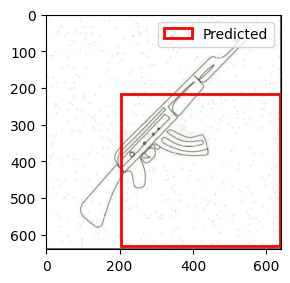

Image: Automatic-Rifle_38_jpeg_jpg.rf.ff194dc1e878f69ce8b3e45bb8a50230.jpg
Predicted class scores: [0.20270628 0.30659127 0.06967632 0.42102614]
1/1 [==============================] - 0s 201ms/step


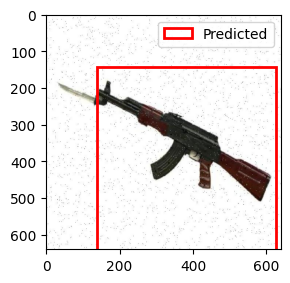

Image: Automatic-Rifle_44_jpeg_jpg.rf.1a5215835f1adc45fb9a83cc8842fb21.jpg
Predicted class scores: [0.03569524 0.6307817  0.05398481 0.27953836]
1/1 [==============================] - 0s 201ms/step


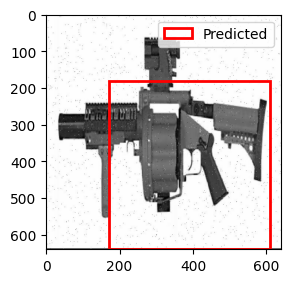

Image: Grenade-Launcher_3_jpeg_jpg.rf.6b130f0c52b250fce7561aaae1f7cb70.jpg
Predicted class scores: [0.12251914 0.60439104 0.15674855 0.11634127]
1/1 [==============================] - 0s 228ms/step


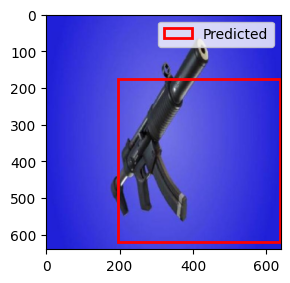

Image: SMG_64_jpeg_jpg.rf.02790b84218c7d760dcce4924edc0f71.jpg
Predicted class scores: [0.25611195 0.13020289 0.04120526 0.57247984]


In [43]:
from tensorflow.keras.preprocessing import image as keras_image
def test_model_on_folder(folder_path, model, num_images=5):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    
    for i, img_file in enumerate(image_files[:num_images]):
        img_path = os.path.join(folder_path, img_file)
        img_array = load_and_preprocess_image(img_path)

        # Get predictions
        predictions = model.predict(img_array)
        pred_classes = predictions[0][0]   # Assuming class_output is the first in the list
        pred_boxes = predictions[1][0]     # Assuming bbox_output is the second in the list
        
        # Display image with predicted boxes
        img = keras_image.load_img(img_path)
        plot_image_with_boxes(np.array(img), [pred_boxes])

        print(f"Image: {img_file}")
        print(f"Predicted class scores: {pred_classes}")
        
        if i >= num_images - 1:
            break

# Test the model on images in a new folder
folder_path = 'try/'  # Specify the path to your new folder
test_model_on_folder(folder_path, model, num_images=5)

